# DAWN Winter School 2022 
### - EAZY Tutorial

This tutorial will show and provide the basics of fitting photometric data with the SED-fitting code EAZY (Brammer et al. 2008). In this example, we will be fitting the Hubble Deep Field North (HDFN) catalog provided with the original EAZY code.

This tutorial will mostly rely on eazy-py (https://github.com/gbrammer/eazy-py).

This tutorial will focus on fitting photometry to derive photometric redshifts and physical quantities, which we will explore to understand the targets in our catalog. We will use different selection criteria, look for interesting objects in the catalog, amongst other things.

### Demo fitting the HDFN catalog provided with the original EAZY code

In [1]:
%matplotlib inline

In [2]:
# environment installation for hosted notebooks
# (e.g., mybinder, GoogleCollab)
import os
orig_wd = os.getcwd()

try:
    import eazy
    HAS_EAZY = True
except:
    HAS_EAZY = False

# mybinder
if ('jovyan' in orig_wd):
    if not HAS_EAZY:
        print('Install on /home/jovyan')

        os.chdir('/home/jovyan')
        !git clone https://github.com/gbrammer/eazy-py.git --recurse-submodule
        os.chdir('/home/jovyan/eazy-py')
        !pip install . -r requirements.txt

        os.chdir(orig_wd)
    
    try:
        import grizli
    except:
        !pip install cython
        !pip install git+https://github.com/gbrammer/grizli
            
# Google collab
if ('/content' in orig_wd):
    if not HAS_EAZY:
        print('Install on /content (Google Collab')

        os.chdir('/content')
        !git clone https://github.com/gbrammer/eazy-py.git --recurse-submodule
        os.chdir('/content/eazy-py')
        !pip install . -r requirements.txt

        os.chdir(orig_wd)
    
    try:
        import grizli
    except:
        !pip install cython
        !pip install git+https://github.com/gbrammer/grizli
            
    try:
        print('EAZYCODE = '+os.getenv('EAZYCODE'))
    except:
        %env EAZYCODE=/content/eazy-py/eazy-photoz/


Install on /home/jovyan
Cloning into 'eazy-py'...
remote: Enumerating objects: 1628, done.
remote: Counting objects: 100% (276/276), done.
remote: Compressing objects: 100% (174/174), done.
remote: Total 1628 (delta 177), reused 181 (delta 100), pack-reused 1352
Receiving objects: 100% (1628/1628), 7.15 MiB | 19.95 MiB/s, done.
Resolving deltas: 100% (1082/1082), done.
Submodule 'eazy-photoz' (https://github.com/gbrammer/eazy-photoz.git) registered for path 'eazy-photoz'
Cloning into '/home/jovyan/eazy-py/eazy-photoz'...
remote: Enumerating objects: 1069, done.        
remote: Counting objects: 100% (153/153), done.        
remote: Compressing objects: 100% (123/123), done.        
remote: Total 1069 (delta 51), reused 127 (delta 28), pack-reused 916        
Receiving objects: 100% (1069/1069), 62.35 MiB | 22.23 MiB/s, done.
Resolving deltas: 100% (389/389), done.
Submodule path 'eazy-photoz': checked out '3a0ff452dbf13d25bb2eb03c19d76b25118fdf52'
Processing /home/jovyan/eazy-py
  Prep

In [3]:
# Module versions
import importlib
import sys
import time
print(time.ctime() + '\n')

print(sys.version + '\n')

for module in ['numpy', 'scipy', 'matplotlib','astropy','eazy', 'prospect']:
    #print(module)
    mod = importlib.import_module(module)
    print('{0:>20} : {1}'.format(module, mod.__version__))

Tue Feb  8 09:42:05 2022

3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]

               numpy : 1.21.5
               scipy : 1.7.3
          matplotlib : 3.5.1
             astropy : 4.3.1
                eazy : 0.5.2.dev33
            prospect : 1.0.0


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

import eazy

# Symlink templates & filters from the eazy-code repository
try:
    print('EAZYCODE = '+os.getenv('EAZYCODE'))
except:
    %env EAZYCODE = /home/jovyan/eazy-py/eazy-photoz

if not os.path.exists('templates'):
    eazy.symlink_eazy_inputs() 

env: EAZYCODE=/home/jovyan/eazy-py/eazy-photoz
/srv/conda/envs/notebook/lib/python3.7/site-packages/eazy/data/templates -> ./templates
/srv/conda/envs/notebook/lib/python3.7/site-packages/eazy/data/filters/FILTER.RES.latest -> ./FILTER.RES.latest


In [5]:
# quiet numpy/astropy warnings
import warnings
from astropy.utils.exceptions import AstropyWarning

np.seterr(all='ignore')
warnings.simplefilter('ignore', category=AstropyWarning)

### Fit Input Parameters

Default parameters are stored in the file `eazy/data/zphot.param.default` in the repository.

The parameters are necessary to fit the catalog, here one specifies the catalog file, the templates to be used in the fitting, the redshift grid, etc. The user input is transparent and easy to implement. The parameters that differ from defaults can be provided in a dictionary as shown below.

In [6]:
params = {}

# Catalog file
params['CATALOG_FILE'] = os.path.join(os.getenv('EAZYCODE'), 'inputs/hdfn_fs99_eazy.cat')

params['MAIN_OUTPUT_FILE'] = 'hdfn.eazypy'

# Galactic extinction
params['MW_EBV'] = 0.0103
params['CAT_HAS_EXTCORR'] = True

# Redshift grid (minimum, maximum and grid step)
params['Z_STEP'] = 0.01
params['Z_MIN'] = 0.01
params['Z_MAX'] = 6.

# Prior files
params['PRIOR_ABZP'] = 25 
params['PRIOR_FILTER'] = 28 # K
params['PRIOR_FILE'] = 'templates/prior_K_TAO.dat'

# Template set to fit photometry
params['TEMPLATES_FILE'] = 'templates/fsps_full/tweak_fsps_QSF_12_v3.param'

# Fix spectroscopic redshift
params['FIX_ZSPEC'] = False

# IGM parameters
params['IGM_SCALE_TAU'] = 1.0

In [7]:
# The translate file will read in the filter bandpasses from the catalog
translate_file = os.path.join(os.getenv('EAZYCODE'), 'inputs/zphot.translate')

# Here we read in the catalog, templates and filters
self = eazy.photoz.PhotoZ(param_file=None, translate_file=translate_file, zeropoint_file=None, 
                          params=params, load_prior=True, load_products=False)

Read default param file: /srv/conda/envs/notebook/lib/python3.7/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: /home/jovyan/eazy-py/eazy-photoz/inputs/hdfn_fs99_eazy.cat
   >>> NOBJ = 1067
f_f300w e_f300w ( 10): hst/wfpc2_f300w.dat
f_f450w e_f450w ( 12): hst/wfpc2_f450w.dat
f_f606w e_f606w ( 14): hst/wfpc2_f606w.dat
f_f814w e_f814w ( 16): hst/wfpc2_f814w.dat
f_irimj e_irimj ( 26): KPNO/IRIMJ
f_irimh e_irimh ( 27): KPNO/IRIMH
f_irimk e_irimk ( 28): KPNO/IRIMK
Set sys_err = 0.01 (positive=True)
Read PRIOR_FILE:  templates/prior_K_TAO.dat
Template grid: templates/fsps_full/tweak_fsps_QSF_12_v3.param (this may take some time)


100%|██████████| 12/12 [00:22<00:00,  1.91s/it]


Template   0: tweak_fsps_QSF_12_v3_001.dat (NZ=1).
Template   1: tweak_fsps_QSF_12_v3_002.dat (NZ=1).
Template   2: tweak_fsps_QSF_12_v3_003.dat (NZ=1).
Template   3: tweak_fsps_QSF_12_v3_004.dat (NZ=1).
Template   4: tweak_fsps_QSF_12_v3_005.dat (NZ=1).
Template   5: tweak_fsps_QSF_12_v3_006.dat (NZ=1).
Template   6: tweak_fsps_QSF_12_v3_007.dat (NZ=1).
Template   7: tweak_fsps_QSF_12_v3_008.dat (NZ=1).
Template   8: tweak_fsps_QSF_12_v3_009.dat (NZ=1).
Template   9: tweak_fsps_QSF_12_v3_010.dat (NZ=1).
Template  10: tweak_fsps_QSF_12_v3_011.dat (NZ=1).
Template  11: tweak_fsps_QSF_12_v3_012.dat (NZ=1).
Process templates: 23.044 s


194it [00:00, 1478.87it/s]


### Now we fit the whole catalog

With the command `self.fit_catalog`, we fit the input catalog.

In [8]:
# Turn off error corrections derived above
self.set_sys_err(positive=True)

# Full catalog
sample = np.isfinite(self.cat['z_spec'])

# fit_parallel renamed to fit_catalog 14 May 2021
self.fit_catalog(self.idx[sample], n_proc=8)

Set sys_err = 0.01 (positive=True)


100%|██████████| 194/194 [00:31<00:00,  6.10it/s]


Compute best fits
fit_best: 0.3 s (n_proc=1,  NOBJ=1023)
Fit 32.6 s (n_proc=8, NOBJ=1067)


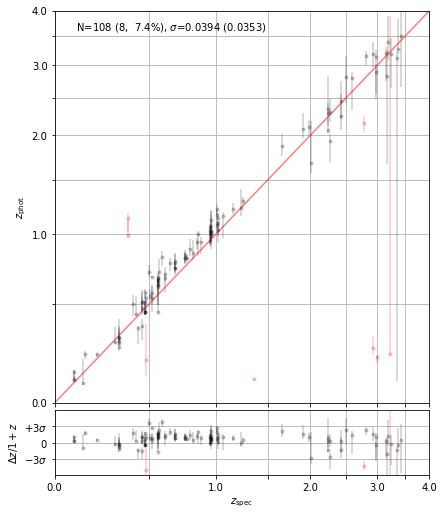

In [9]:
# Show zspec-zphot comparison
fig = self.zphot_zspec()

### Derived parameters (z params, RF colors, masses, SFR, etc.)

With `self.standard_output` we can obtain the derived parameters from the fitting, this includes rest-frame colours, star formation rates, photometric redshifts, stellar masses, etc.

In [10]:
warnings.simplefilter('ignore', category=RuntimeWarning)
zout, hdu = self.standard_output(rf_pad_width=0.5, rf_max_err=2, 
                                 prior=True, beta_prior=True)

# 'zout' also saved to [MAIN_OUTPUT_FILE].zout.fits

Get best fit coeffs & best redshifts
fit_best: 6.5 s (n_proc=1,  NOBJ=1046)
Get parameters (UBVJ=[153, 154, 155, 161], simple=False)


100%|██████████| 1046/1046 [07:34<00:00,  2.30it/s]


Abs Mag filters [271, 272, 274]
Rest-frame filters:
~~~~~~~~~~~~~~~~~~~ 
   0 RestUV/Tophat_1700_200.dat lambda_c= 1.6989e+03 AB-Vega=1.916 w95=190.7
   1 RestUV/Tophat_2200_200.dat lambda_c= 2.1993e+03 AB-Vega=1.691 w95=191.1
   2 RestUV/Tophat_2800_200.dat lambda_c= 2.7996e+03 AB-Vega=1.465 w95=191.2


100%|██████████| 1046/1046 [02:08<00:00,  8.13it/s]


In [11]:
# the 'zout' object has all the derived physical properties, which can be seen by using the command below:
zout.colnames

['id',
 'z_spec',
 'nusefilt',
 'z_ml',
 'z_ml_chi2',
 'z_ml_risk',
 'lc_min',
 'lc_max',
 'z_phot',
 'z_phot_chi2',
 'z_phot_risk',
 'z_min_risk',
 'min_risk',
 'z_raw_chi2',
 'raw_chi2',
 'z025',
 'z160',
 'z500',
 'z840',
 'z975',
 'restU',
 'restU_err',
 'restB',
 'restB_err',
 'restV',
 'restV_err',
 'restJ',
 'restJ_err',
 'dL',
 'Lv',
 'mass',
 'sfr',
 'LIR',
 'energy_abs',
 'Av',
 'lw_age_V',
 'MLv',
 'Lv_p',
 'mass_p',
 'LIR_p',
 'sfr_p',
 'Av_p',
 'ssfr_p',
 'rest270',
 'rest270_err',
 'rest274',
 'rest274_err',
 'rest120',
 'rest120_err',
 'rest121',
 'rest121_err',
 'rest156',
 'rest156_err',
 'rest157',
 'rest157_err',
 'rest158',
 'rest158_err',
 'rest159',
 'rest159_err',
 'rest160',
 'rest160_err',
 'rest161',
 'rest161_err',
 'rest162',
 'rest162_err',
 'rest163',
 'rest163_err',
 'DISTMOD',
 'ABSM_271',
 'ABSM_272',
 'ABSM_274']

In [12]:
# it also contains relevant information about the fit performed, templates used, etc. 
# this information can be accessed
zout.meta

OrderedDict([('version', ('0.5.2.dev33', 'Eazy-py version')),
             ('prior', (True, 'Prior applied (templates/prior_K_TAO.dat)')),
             ('betprior', (True, 'Beta prior applied')),
             ('fitter', ('nnls', 'Optimization method for template fits')),
             ('SYS_ERR', 0.01),
             ('TEMP_ERR_FILE', 'templates/uvista_nmf/template_error_10.def'),
             ('TEMP_ERR_A2', 0.2),
             ('PRIOR_FILTER', 28),
             ('PRIOR_ABZP', 25),
             ('IGM_SCALE_TAU', 1.0),
             ('APPLY_IGM', 'y'),
             ('TEMPLATES_FILE',
              'templates/fsps_full/tweak_fsps_QSF_12_v3.param'),
             ('TEMPL000', 'tweak_fsps_QSF_12_v3_001.dat'),
             ('TEMPL001', 'tweak_fsps_QSF_12_v3_002.dat'),
             ('TEMPL002', 'tweak_fsps_QSF_12_v3_003.dat'),
             ('TEMPL003', 'tweak_fsps_QSF_12_v3_004.dat'),
             ('TEMPL004', 'tweak_fsps_QSF_12_v3_005.dat'),
             ('TEMPL005', 'tweak_fsps_QSF_12_v3_006.d

## Exploring the output

Once we have fitted our catalog with EAZY and derived multiple physical parameters, we can explore the properties of our sample, as well as individual objects. Here we show some examples of different analyses that one can perform with the EAZY output.

### UVJ diagram

Part of what makes understanding galaxy evolution so challenging is the wealth of galaxy properties. Explaining the evolution of all these properties and the correlation between them is a daunting task. Two-colour diagrams have been shown to be a useful and simple mechanism for comprehending astronomical objects, in particular the $UVJ$ diagram, which is obtained by plotting the rest-frame $U − V$ versus $V − J$ colours.

The $UVJ$ diagram separates quiescent from star forming galaxies (SFGs). It is particularly useful due to its ability to break the degeneracy between age and reddening for red galaxies: in most cases, galaxies with blue UV colours display rather dust-free star formation activity, whereas galaxies can appear red due to dust obscuration or being quiescent, since evolved older stellar populations will dominate. On the other hand, quiescent galaxies unobscured by dust are blue in $VJ$, therefore they will be in a different position than the SFGs in the $UVJ$ plane, leaving the two types of sources empirically set apart. Williams et al., 2009 (https://arxiv.org/abs/0806.0625), determined a border between the two regions that is still relevant and is being used in the present-day.

In [13]:
# make uv and vj colours 
zout['uv'] = -2.5*np.log10(zout['restU']/zout['restV'])
zout['vj'] = -2.5*np.log10(zout['restV']/zout['restJ'])

# calculate specific star formation rate 

zout['ssfr'] = np.log10(zout['sfr']/zout['mass'])

# select galaxies at 0.2<z<1

sel = (zout['z_phot'] > 0.2) & (zout['z_phot'] < 1.) 

# function that takes a catalogue with uvj colours and makes uvj diagram coloured by ssfr. 

def uvj(cat,save=False):

    labels = { 'z' :r'$z_{phot}$', 
         'mass' : r'Stellar mass [$M_{\odot}$]',
         'ssfr': r'sSFR [$yr^{-1}$] (past 100Myr)',
          'sfr': r'SFR [$M_{\odot}yr^{-1}$]',
         'fsize': 20}
    
    def sep_line(vj):
        if vj<0.75:
            uv = 1.3
        if vj>0.75:
            uv = 0.8*(vj)+0.7
        if vj>1.5:
            uv = 0.
        return uv


    plt.figure(figsize=(10,8))
    sc = plt.scatter(cat['vj'],cat['uv'],\
                    c=cat['ssfr'],cmap='viridis',\
                s=5, alpha=0.9)
    cb = plt.colorbar(sc)
    cb.set_label(labels['ssfr'],fontsize=labels['fsize'])

    plt.xlabel('V-J',fontsize=labels['fsize'])
    plt.ylabel('U-V',fontsize=labels['fsize'])

    plt.grid(alpha=0.7)

    plt.xlim(-0.5,3)
    plt.ylim(-0.5,3)

    vj = np.arange(-1,1.6,0.1)
    uv = [sep_line(v) for v in vj]
    plt.vlines(x=1.5, ymin=1.9,ymax = 3,color='black',ls='dashed',alpha=0.8)

    plt.plot(vj,uv,c='black',ls='dashed',alpha=0.8)
    
    if save:
        plt.savefig('uvj-test.pdf')

Text(1.55, 2.5, 'Dusty star forming')

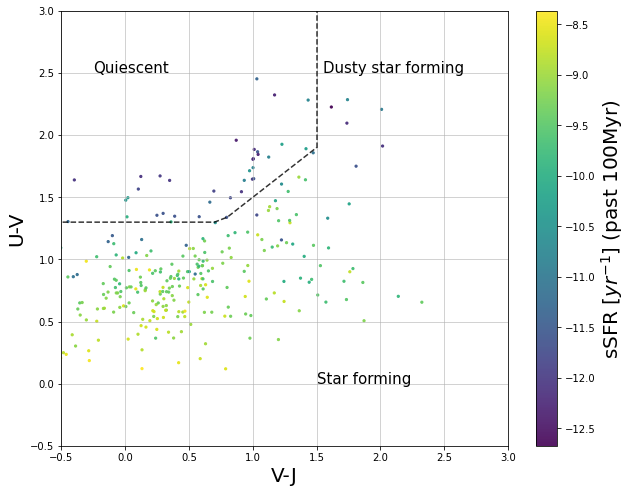

In [14]:
# plot the uvj diagram 

uvj(zout[sel])

plt.text(-0.25,2.5,s='Quiescent',fontsize=15)
plt.text(1.5,0,s='Star forming',fontsize=15)
plt.text(1.55,2.5,s='Dusty star forming',fontsize=15)

As can be seen above, the $UVJ$ diagram can separate quiescent galaxies from star-forming galaxies, and moreover, break the degeneracy with dusty-star forming galaxies (which lay on the upper right end of the diagram).


### Selecting bright objects

Another exciting avenue is to select interesting objects, such as the brightest objects with z_spec > 1. The command `self.show_fit` allows us to plot the resulting SED-fit, as well as the redshift probability density function, where we can see the spectroscopic redshift and the photo-z PDF.

Besides this, the `self.cat` contains the whole catalog, and can be used to perform different selections based on various criteria.

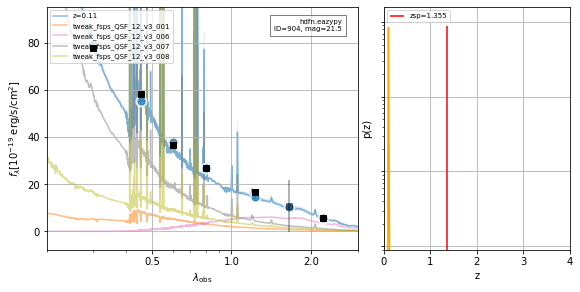

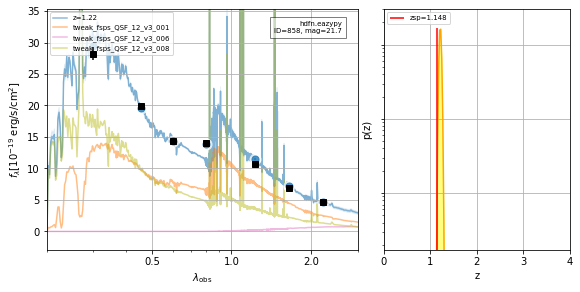

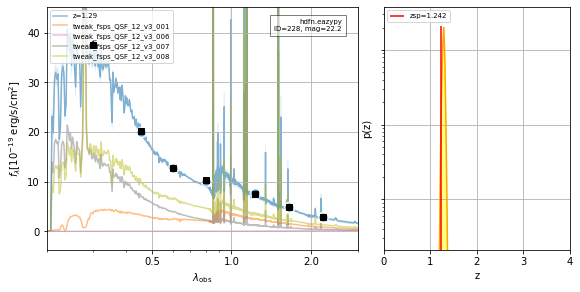

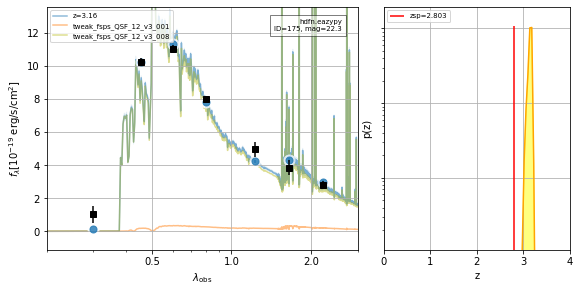

In [15]:
# Show brightest objects with z_spec > 1
imag = params['PRIOR_ABZP'] - 2.5*np.log10(self.cat['f_f814w'])
sel = (self.cat['z_spec'] > 1.1)

so = np.argsort(imag[sel])
ids = self.cat['id'][sel][so]

for i in range(4):
    fig, data = self.show_fit(ids[i], xlim=[0.2, 3], show_components=True,
                              logpz=True, zr=[0,4])

## Concluding Remarks

This tutorial has hopefully taught you to extract and derive basic galaxy properties from photometric data, including fitting photometric redshifts, exploring the UVJ diagram and its implications, analysing galaxy spectral energy distributions and selecting interesting objects from a large catalog.


# Proposed Exercises

1. Find the most massive galaxy in the sample and the highest redshift candidate.

---

2. Explore the UVJ diagram, and make a sub-sample of quiescent galaxies according to the Williams+09 (https://arxiv.org/pdf/0806.0625.pdf) selection criteria.

(U −V) > 0.88×(V −J)+0.69

(U −V) > 0.88×(V −J)+0.59

(U −V) > 0.88×(V −J)+0.49

Additional criteria of U − V > 1.3 and V − J < 1.6 are applied to the quiescent galaxies at all redshifts to prevent contamination from unobscured and dusty star–forming galaxies, respectively.

---

3. Select the object with ID=716, and compare its spectral energy distribution (SED) with some SEDs from your previous quiescent galaxy population selection. Do they look the same? If not, why? You can also check its physical properties such as SFR and mass. Do you think the object with ID=716 is a quiescent galaxy? If not, what kind of galaxy do you think it is? 

---

4. Plot the PDF(z) of a quiescent galaxy, a blue star-forming galaxy and a red star-forming galaxy (you can use `self.show_fit` with `logpz=True`). Are there differences in the uncertainty on the photo-z for the different populations?

---

5. Try to find the most interesting object by your own liking/criteria (think about what most interesting could involve - brightest? highest mass? highest redshift? most quiescent?)

---

## Extra exercise

6. Explore the redshift vs K-band relation and the redshift vs Mass for the whole catalog. What can you tell about completeness of the sample? (see e.g. Pozetti+2010)